In [74]:
import numpy as np
import pandas as pd
import math

from scipy.integrate import odeint
from scipy.special import lambertw
from scipy.optimize import linprog

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec


plt.rcParams.update({'font.size':15})
plt.rcParams.update({'axes.labelpad':9})
plt.rc('font', family = 'Times New Roman')


In [110]:
def CPR(se,sp,n,p):
    if n <= 1:
        cpr_n = 1/(se*p)
    else:
        cpr_n = 1/(se**2*p)*(1/n + se-(se+sp-1)*(1-p)**n)
    return cpr_n

    
def results(se, sp, n, p):
    if n ==1:
        TP = se*p
        FP = (1-p)*(1-sp)
        TN = sp*(1-p)
        FN = p*(1-se)
        
        PPV = TP/(TP+FP)
        NPV = TN/(TN+FN)
        
    else:
        TP = se**2*p
        FP = se*(1-p)*(1-sp)-(1-sp)*(se+sp-1)*(1-p)**n
        TN = (1-p) - FP
        FN = p - TP
        
        
        PPV = TP/(TP+FP)
        NPV = TN/(TN+FN)
        
    return PPV,NPV,TP,FP    
        
    
def find_opt_size_continuous(se, sp, p):
    p_threshold = 1 -  np.exp((-1)*(se+sp-1)/(np.exp(1)))
    if p < p_threshold:
        x = (-1/2)*np.sqrt(np.log(1/(1-p))/(se+sp-1)) 
        n_0 = np.real(2/(np.log(1-p))*lambertw(x))
    else:
        n_0 = 1
    return n_0

def find_opt_size_integer(se,sp,n_0,p):
    
    
    cpr_it = CPR(se,sp,1,p)
    cpr_pt_lower = CPR(se,sp,np.floor(n_0),p)   
    cpr_pt_upper = CPR(se,sp,np.ceil(n_0),p)
    
    n_list = [np.floor(n_0),np.ceil(n_0),1,]
    cpr_list = [cpr_pt_lower,cpr_pt_upper,cpr_it,]
        
    n_opt = min(n_list[np.argmin(cpr_list)],32)
    cpr_opt = CPR(se,sp,n_opt,p)
    
    return n_opt,cpr_opt,cpr_it



In [127]:
def deriv_testing(y, test_type, R_t, gamma_0, C_0, se, sp):
#     print('test_type',test_type)
    S, I, R, TCT,TFP = y
    beta = R_t*gamma_0
    
    n = 0
    cpr = 0
    FP = 0
    TP = 0
    PPV = 0
    NPV = 0
    test_capacity = 0
    test_result = 0
#individual testing
    if test_type == 1:
        n = 1
        cpr = 1/(se*I)
        eff = 1
        test_capacity = C_0
        test_result = test_capacity/eff
        PPV,NPV,TP,FP = results(se, sp, n, I)
#         print('individual_test_result',test_result)
# pooled testing         
    elif test_type == 2:
        n_0 = find_opt_size_continuous(se,sp,I)
        n,cpr,cpr_i = find_opt_size_integer(se,sp,n_0,I)  
        test_capacity = C_0
        eff = 1/n + se-(se+sp-1)*(1-I)**n
        test_result = test_capacity/eff
        PPV,NPV,TP,FP = results(se, sp, n, I)
    
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma_0 * I - test_result*TP
    dRdt = gamma_0 * I + test_capacity*TP   
    dTCT = test_result
    dTFP = FP*test_result
    
    return dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV

In [119]:
def Check_null(dy):
  
    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV  = dy      
    if math.isnan(dSdt):
        dSdt = 0
    if math.isnan(dIdt):
        dIdt = 0                                       
    if math.isnan(dRdt):
        dRdt = 0 
    if math.isnan(dTCT):
        dTCT = 0 
    if math.isnan(dTFP):
        dTFP = 0 

    return  dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV

## Figure 1

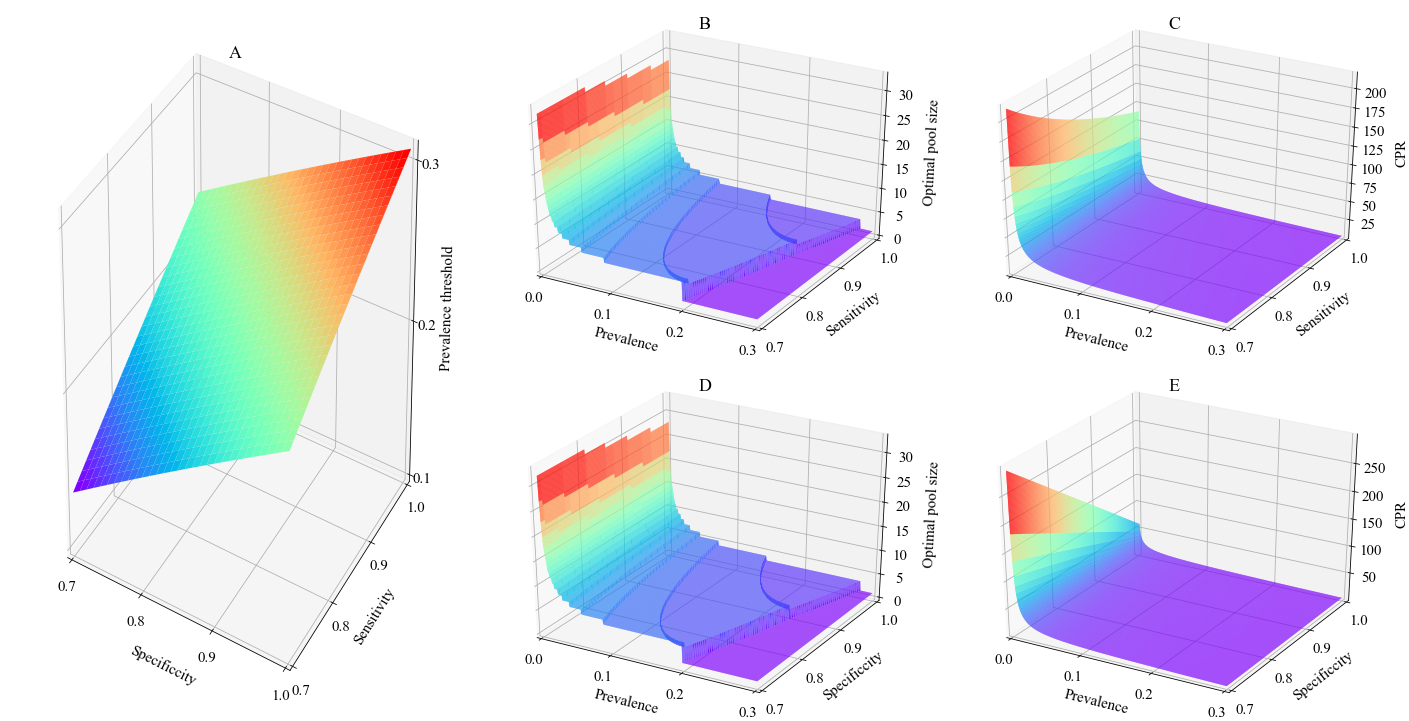

<Figure size 432x288 with 0 Axes>

In [144]:
fig = plt.figure(figsize=(25,13))
gs = GridSpec(2,3, figure=fig)
ax1 = fig.add_subplot(gs[0:,0], projection='3d')
ax2 = fig.add_subplot(gs[0,-2], projection='3d')
ax3 = fig.add_subplot(gs[0,-1], projection='3d')
ax4 = fig.add_subplot(gs[-1,-2], projection='3d')
ax5 = fig.add_subplot(gs[-1,-1], projection='3d')

sp = np.arange(0.7, 1, 0.01)
se = np.arange(0.7, 1, 0.01)
sp, se = np.meshgrid(sp, se)
p_lb = 1 -  np.exp((-1)*(se+sp-1)/(np.exp(1)))
ax1.plot_surface(sp, se, p_lb, rstride=1, cstride=1, cmap='rainbow')



p = np.arange(0.0015, 0.3, 0.001)
se = np.arange(0.7, 1, 0.001)
sp = 0.9
p, se = np.meshgrid(p, se)
xx = (-1/2)*np.sqrt(np.log(1/(1-p))/(se+sp-1)) 
n_0 =np.real(2/(np.log(1-p))*lambertw(xx))  
cpr_n_0 =((1/n_0 +(se-(se+sp-1)*(1-p)**n_0))/(se**2*p)) 
cpr_n_i = 1/(se*p)


for i in range(len(n_0)):
    for j in range(len(n_0[0])):
        n_0[i][j],cpr_n_0[i][j],cpr_n_i[i][j] = find_opt_size_integer(se[i][j],sp, n_0[i][j],p[i][j])


ax2.plot_surface(p, se, n_0, rstride=1, cstride=1, cmap='rainbow')
ax3.plot_surface(p, se, cpr_n_0, rstride=1, cstride=1, cmap='rainbow')

ax1.set_xlabel('Specificcity')
ax1.set_xlim(0.7, 1)  #拉开坐标轴范围显示投影
ax1.set_ylabel('Sensitivity')
ax1.set_ylim(0.7, 1)
ax1.set_zlabel('Prevalence threshold')
ax1.set_title('A')
a = np.linspace(0.7, 1, 4)
b = np.linspace(0.1, 0.3,3)
ax1.set_xticks(a)
ax1.set_yticks(a)
ax1.set_zticks(b)



p = np.arange(0.0015, 0.3,0.001)
sp = np.arange(0.7, 1, 0.001)
se = 0.9
p, sp = np.meshgrid(p, sp)
xx = (-1/2)*np.sqrt(np.log(1/(1-p))/(se+sp-1)) 
n_0 =np.round(np.real(2/(np.log(1-p))*lambertw(xx)))   
cpr_n_0 =((1/n_0 +(se-(se+sp-1)*(1-p)**n_0))/(se**2*p)) 
cpr_n_i = 1/(se*p)

for i in range(len(n_0)):
    for j in range(len(n_0[0])):
        n_0[i][j],cpr_n_0[i][j],cpr_n_i[i][j] = find_opt_size_integer(se,sp[i][j], n_0[i][j],p[i][j])

ax4.plot_surface(p,sp, n_0, rstride=1, cstride=1, cmap='rainbow')
ax5.plot_surface(p,sp, cpr_n_0, rstride=1, cstride=1, cmap='rainbow')


ax2.set_xlabel('Prevalence',linespacing=3.2)
ax2.set_xlim(0, 0.3)  
ax2.set_ylabel('Sensitivity')
ax2.set_ylim(0.7, 0.99)
ax2.set_zlabel('Optimal pool size')
ax2.set_zlim(0, 33)
ax2.set_title('B')
c = np.linspace(0, 0.3,4)
ax2.set_xticks(c)
ax2.set_yticks(a)

ax3.set_xlabel('Prevalence')
ax3.set_xlim(0, 0.3)  
ax3.set_ylabel('Sensitivity')
ax3.set_ylim(0.7, 0.99)
ax3.set_zlabel('CPR',rotation=90)
ax3.set_title('C')
ax3.set_xticks(c)
ax3.set_yticks(a)


ax4.set_xlabel('Prevalence',linespacing=3.2)
ax4.set_xlim(0, 0.3)  
ax4.set_ylabel('Specificcity')
ax4.set_ylim(0.7, 0.99)
ax4.set_zlabel('Optimal pool size')
ax4.set_zlim(0, 33)
ax4.set_title('D')
c = np.linspace(0, 0.3,4)
ax4.set_xticks(c)
ax4.set_yticks(a)

ax5.set_xlabel('Prevalence')
ax5.set_xlim(0, 0.3)  
ax5.set_ylabel('Specificcity')
ax5.set_ylim(0.7, 0.99)
ax5.set_zlabel('CPR',rotation=90)
ax5.set_title('E')
ax5.set_xticks(c)
ax5.set_yticks(a)


plt.subplots_adjust(hspace=0.05, wspace=0.03)

plt.show()
plt.savefig('Figure_1.pdf',bbox_inches = 'tight')

## Figure 2

In [151]:
data = pd.read_csv('./1102.csv') 
data['N_OPT_INT'] = None
data['CPR_P'] = None
data['CPR_I'] = None

se = 0.7
sp = 0.95 

for i in range(len(data)):
  p_7day_mean = data.iloc[i, 1]

  N_0_m = find_opt_size_continuous(se, sp, p_7day_mean)
  if (p_7day_mean>0):
    N_opt_m,cpr_opt_m,cpr_i_m = find_opt_size_integer(se, sp, N_0_m, p_7day_mean)
  else:
    N_opt_m,cpr_opt_m,cpr_i_m = 32,10000,10000

  data.iloc[i, 2] = N_opt_m
  data.iloc[i, 3] = cpr_opt_m 
  data.iloc[i, 4] = cpr_i_m 
data = data.sort_values(by=['pos_rate_T_days'],ascending= False)
data

,State,pos_rate_T_days,N_OPT_INT,CPR_P,CPR_I
41,SD,0.506,1,2.82326,2.82326
15,IA,0.374,1,3.81971,3.81971
16,KS,0.360,1,3.96825,3.96825
12,ID,0.334,1,4.27716,4.27716
50,WY,0.304,1,4.69925,4.69925
0,AL,0.196,4,7.06367,7.28863
26,MT,0.176,4,7.5411,8.11688
44,UT,0.153,4,8.20943,9.33707
49,WI,0.147,4,8.4115,9.71817
38,PA,0.144,4,8.51777,9.92063


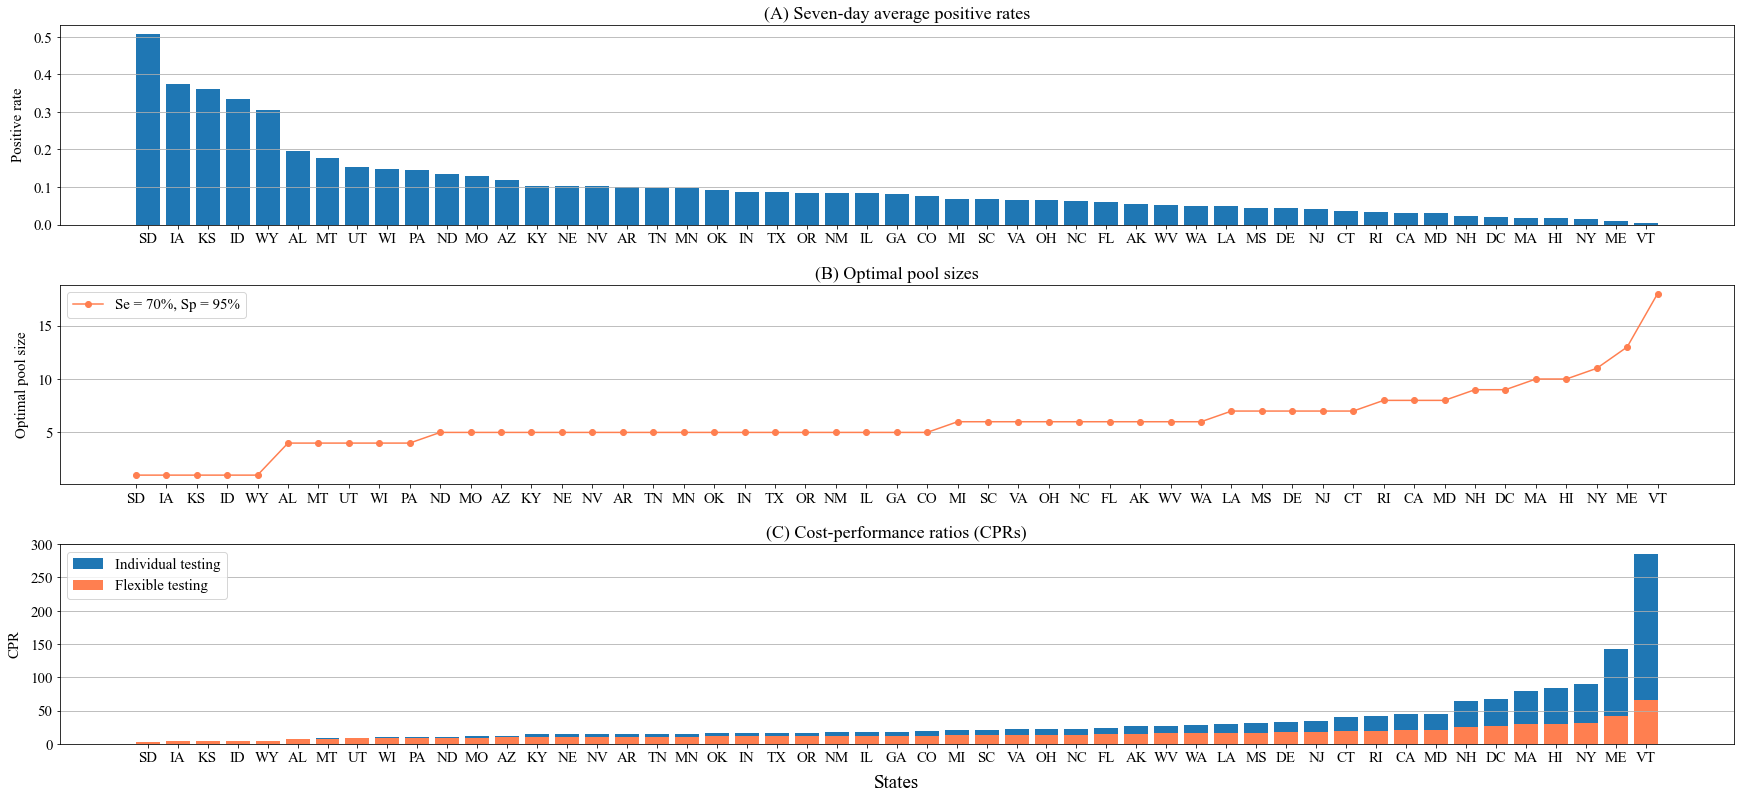

In [148]:
fig = plt.figure(figsize=(30,18))
ax_1 = fig.add_subplot(4,1,1)
ax_2 = fig.add_subplot(4,1,2)
ax_3 = fig.add_subplot(4,1,3)
ax_1.grid(axis='y')
ax_1.set_title(label='(A) Seven-day average positive rates', loc='center')


ax_1.bar(data.State,data.pos_rate_T_days)
ax_1.set_ylabel('Positive rate')

ax_2.plot(data.State,data['N_OPT_INT'],label= 'Se = 70%, Sp = 95%', marker = "o",color = 'coral' )
ax_2.set_title(label='(B) Optimal pool sizes', loc='center')
ax_2.set_ylabel('Optimal pool size')
ax_2.grid(axis='y')
ax_2.legend()

ax_3.set_title(label='(C) Cost-performance ratios (CPRs)', loc='center')
ax_3.bar(data.State,data['CPR_I'],label= 'Individual testing')
ax_3.bar(data.State,data['CPR_P'],label= 'Flexible testing',color = 'coral')
ax_3.set_ylabel('CPR')
ax_3.set_xlabel('States',fontsize=19)
ax_3.grid(axis='y')

ax_3.legend()
plt.subplots_adjust( wspace=0, hspace =0.3)#调整子图间距
plt.savefig('Figure_2.pdf',bbox_inches = 'tight')

## Figure 3

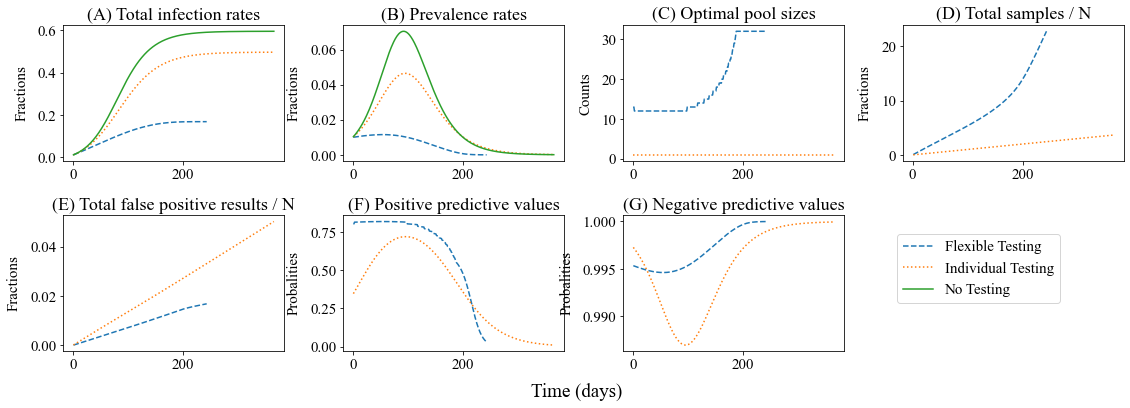

In [128]:
N = 1
T_end = 365
dt = 1

t = np.linspace(1, T_end, T_end*dt)

p = [0.01]
R_t = [1.5]
C_0 = [0.01]

se = [0.733]
sp = 0.986

gamma_0 = 1/14
alpha = 0.00001


for si in range(len(se)):
    for ri in range(len(R_t)):
        for ci in range(len(C_0)):
            for pi in range(len(p)):
                SIM_result_g = []
                SIM_result_i = []
                SIM_result_0 = []
                
                
                # Initial number of infected and recovered individuals, I0 and R0.                
                I0, R0, TCT0, TFP0 = p[pi],0, 0, 0
                S0 = N - I0 - R0
                
# no testing
                y_0 = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_0, I_0, R_0, TCT_0,TFP_0 = y_0
                test_type = 0

                for ti in t:
                    dy_0 = deriv_testing(y_0, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_0)                    
                    S_0 += dSdt*dt
                    I_0 += dIdt*dt
                    R_0+= dRdt*dt
                    TCT_0+=dTCT*dt
                    TFP_0+=dTFP*dt                      
                    y_0 = S_0, I_0, R_0, TCT_0, TFP_0
                    SIM_result_0.append([ti,S_0,I_0,R_0,TCT_0,TFP_0,n,cpr,PPV,NPV])
                
# Pooled testing
                y_g = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_g, I_g, R_g, TCT_g,TFP_g = y_g
                test_type = 2
                
                for ti in t:                   
                    dy_g = deriv_testing(y_g, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_g) 
                    S_g += dSdt*dt
                    I_g += dIdt*dt
                    R_g += dRdt*dt
                    TCT_g += dTCT*dt
                    TFP_g += dTFP*dt                      
                    y_g = S_g, I_g, R_g, TCT_g,TFP_g
                    
                    SIM_result_g.append([ti,S_g,I_g,R_g,TCT_g,TFP_g,n,cpr,PPV,NPV])
                    
                    
# Individual testing
                y_i = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_i, I_i, R_i, TCT_i,TFP_i = y_i
                test_type = 1 
                
                for ti in t:                   
                    dy_i = deriv_testing(y_i, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_i) 
                    S_i += dSdt*dt
                    I_i += dIdt*dt
                    R_i += dRdt*dt
                    TCT_i += dTCT*dt
                    TFP_i += dTFP*dt                      
                    y_i = S_i, I_i, R_i, TCT_i,TFP_i
                    
                    SIM_result_i.append([ti,S_i,I_i,R_i,TCT_i,TFP_i,n,cpr,PPV,NPV])
                    
                SIM_0 = pd.DataFrame(data=np.array(SIM_result_0), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                SIM_g = pd.DataFrame(data=np.array(SIM_result_g), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                SIM_i = pd.DataFrame(data=np.array(SIM_result_i), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])  

                 
                SIM_g_alpha = SIM_g.loc[SIM_g.I >= alpha]
                SIM_i_alpha = SIM_i.loc[SIM_i.I >= alpha]
                SIM_0_alpha = SIM_0.loc[SIM_0.I >= alpha]

                

                fig = plt.figure(figsize=(19,6))

                ax_1 = fig.add_subplot(2,4,1)
                ax_2 = fig.add_subplot(2,4,2)
                ax_3 = fig.add_subplot(2,4,3)
                ax_4 = fig.add_subplot(2,4,4)            
                ax_5 = fig.add_subplot(2,4,5)
                ax_6 = fig.add_subplot(2,4,6)
                ax_7 = fig.add_subplot(2,4,7)
            
            
                ax_1.plot(SIM_g_alpha.t,1-SIM_g_alpha.S,label='Flexible Testing', linestyle='dashed')
                ax_1.plot(SIM_i_alpha.t,1-SIM_i_alpha.S,label='Individual Testing', linestyle='dotted')           
                ax_1.plot(SIM_0_alpha.t,1-SIM_0_alpha.S,label='No Testing', linestyle='solid')
                ax_1.set_title('(A) Total infection rates')
                ax_1.set_ylabel('Fractions')
              
                
                ax_2.plot(SIM_g_alpha.t,SIM_g_alpha.I,label='FT', linestyle='dashed')
                ax_2.plot(SIM_i_alpha.t,SIM_i_alpha.I,label='IT', linestyle='dotted')
                ax_2.plot(SIM_0_alpha.t,SIM_0_alpha.I,label='NT', linestyle='solid')
                ax_2.set_ylabel('Fractions')               
                ax_2.set_title('(B) Prevalence rates')                
                
                
                ax_3.plot(SIM_g_alpha.t,SIM_g_alpha.n,label='FT_n', linestyle='dashed')
                ax_3.plot(SIM_i_alpha.t,SIM_i_alpha.n,label='IT_n', linestyle='dotted')
                ax_3.set_ylabel('Counts')
                ax_3.set_title('(C) Optimal pool sizes') 

                ax_4.plot(SIM_g_alpha.t,SIM_g_alpha.TCT,label='FT_TC', linestyle='dashed')
                ax_4.plot(SIM_i_alpha.t,SIM_i_alpha.TCT,label='IT_TC', linestyle='dotted')  
                ax_4.set_ylabel('Fractions')
                ax_4.set_title('(D) Total samples / N') 
                                
                
                ax_5.plot(SIM_g_alpha.t,SIM_g_alpha.TFP,label='FT_TC', linestyle='dashed')
                ax_5.plot(SIM_i_alpha.t,SIM_i_alpha.TFP,label='IT_TC', linestyle='dotted')  
                ax_5.set_ylabel('Fractions')
                ax_5.set_title('(E) Total false positive results / N')                 
                
                ax_6.plot(SIM_g_alpha.t,SIM_g_alpha.PPV,label='FT', linestyle='dashed')
                ax_6.plot(SIM_i_alpha.t,SIM_i_alpha.PPV,label='IT', linestyle='dotted')
                ax_6.set_ylabel('Probalities')
                ax_6.set_title('(F) Positive predictive values')                
                
                ax_7.plot(SIM_g_alpha.t,SIM_g_alpha.NPV,label='FT_FP', linestyle='dashed')
                ax_7.plot(SIM_i_alpha.t,SIM_i_alpha.NPV,label='IT_FP', linestyle='dotted')
                ax_7.set_ylabel('Probalities')
                ax_7.set_title('(G) Negative predictive values')
                
  
                
                
ax_1.legend(loc='lower center', bbox_to_anchor=(4.15,-1.1),ncol=1)

fig.text(0.5, 0.02,'Time (days)', ha='center',fontsize=19 )
plt.subplots_adjust( wspace=0.27, hspace =0.4)

plt.savefig('Figure3.pdf',bbox_inches = 'tight')
                

## Figure 4

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


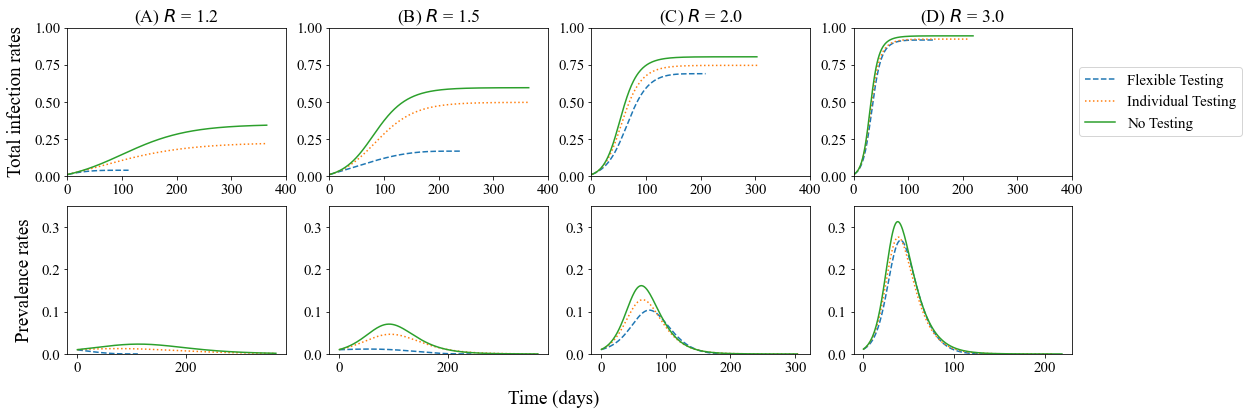

In [136]:
# # Total population, N.
# N = 1

# # A grid of time points (in days)
# t = np.linspace(0, 365, 365)

# p = [0.01]

# # R_0 = [1.5,2,2.5,3.5]

# R_0 = 2
# x = [0.6,0.75,1,1.5]


R_t = [1.2,1.5,2,3]
tit_lis = ['A','B','C','D']






for si in range(len(se)):
    for pi in range(len(p)):
        for ci in range(len(C_0)):
            fig = plt.figure(figsize=(18,6))
            
            for ri in range(len(R_t)):
                
                SIM_result_g = []
                SIM_result_i = []
                SIM_result_0 = []
                
                # Initial number of infected and recovered individuals, I0 and R0.                
                I0, R0, TCT0, TFP0 = p[pi],0, 0, 0
                S0 = N - I0 - R0
                
# no testing
                y_0 = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_0, I_0, R_0, TCT_0,TFP_0 = y_0
                test_type = 0

                for ti in t:
                    dy_0 = deriv_testing(y_0, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_0)                    
                    S_0 += dSdt*dt
                    I_0 += dIdt*dt
                    R_0+= dRdt*dt
                    TCT_0+=dTCT*dt
                    TFP_0+=dTFP*dt                      
                    y_0 = S_0, I_0, R_0, TCT_0, TFP_0
                    SIM_result_0.append([ti,S_0,I_0,R_0,TCT_0,TFP_0,n,cpr,PPV,NPV])
                
# Pooled testing
                y_g = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_g, I_g, R_g, TCT_g,TFP_g = y_g
                test_type = 2
                
                for ti in t:                   
                    dy_g = deriv_testing(y_g, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_g) 
                    S_g += dSdt*dt
                    I_g += dIdt*dt
                    R_g += dRdt*dt
                    TCT_g += dTCT*dt
                    TFP_g += dTFP*dt                      
                    y_g = S_g, I_g, R_g, TCT_g,TFP_g
                    
                    SIM_result_g.append([ti,S_g,I_g,R_g,TCT_g,TFP_g,n,cpr,PPV,NPV])
                    
                    
# Individual testing
                y_i = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_i, I_i, R_i, TCT_i,TFP_i = y_i
                test_type = 1 
                
                for ti in t:                   
                    dy_i = deriv_testing(y_i, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_i) 
                    S_i += dSdt*dt
                    I_i += dIdt*dt
                    R_i += dRdt*dt
                    TCT_i += dTCT*dt
                    TFP_i += dTFP*dt                      
                    y_i = S_i, I_i, R_i, TCT_i,TFP_i
                    
                    SIM_result_i.append([ti,S_i,I_i,R_i,TCT_i,TFP_i,n,cpr,PPV,NPV])
                    
                SIM_0 = pd.DataFrame(data=np.array(SIM_result_0), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                SIM_g = pd.DataFrame(data=np.array(SIM_result_g), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                SIM_i = pd.DataFrame(data=np.array(SIM_result_i), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])  

                 
                SIM_g_alpha = SIM_g.loc[SIM_g.I >= alpha]
                SIM_i_alpha = SIM_i.loc[SIM_i.I >= alpha]
                SIM_0_alpha = SIM_0.loc[SIM_0.I >= alpha]

              
                
                ax_1 = fig.add_subplot(2,len(R_t),ri+1)
                ax_1.plot(SIM_g_alpha.t,1-SIM_g_alpha.S,label='Flexible Testing', linestyle='dashed')                
                ax_1.plot(SIM_i_alpha.t,1-SIM_i_alpha.S,label='Individual Testing', linestyle='dotted')                
                ax_1.plot(SIM_0_alpha.t,1-SIM_0_alpha.S,label='No Testing', linestyle='solid')

                
                ax_2 = fig.add_subplot(2,len(R_t),ri+5)
                ax_2.plot(SIM_g_alpha.t,SIM_g_alpha.I,label='Flexible Testing', linestyle='dashed')
                ax_2.plot(SIM_i_alpha.t,SIM_i_alpha.I,label='Individual Testing', linestyle='dotted')
                ax_2.plot(SIM_0_alpha.t,SIM_0_alpha.I,label='No Testing', linestyle='solid')

                ax_1.set_ylim(0,1)
                ax_1.set_xlim(0,400)
                ax_1.set_xticks(np.linspace(0,400,5))
                ax_1.set_yticks(np.linspace(0,1,5))
                ax_2.set_ylim(0,0.35)

                ax_1.set_title('(%s) '%tit_lis[ri]+r'$R$ = %0.01f'%(R_t[ri]))
                if ri==0: 
                    ax_1.set_ylabel('Total infection rates',fontsize=19)
                    ax_2.set_ylabel('Prevalence rates',fontsize=19)
                                        
            ax_1.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
fig.text(0.5, 0.01,'Time (days)', ha='center',fontsize=19)                               

plt.savefig('Figure_4.pdf',bbox_inches = 'tight')


## Figure 5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


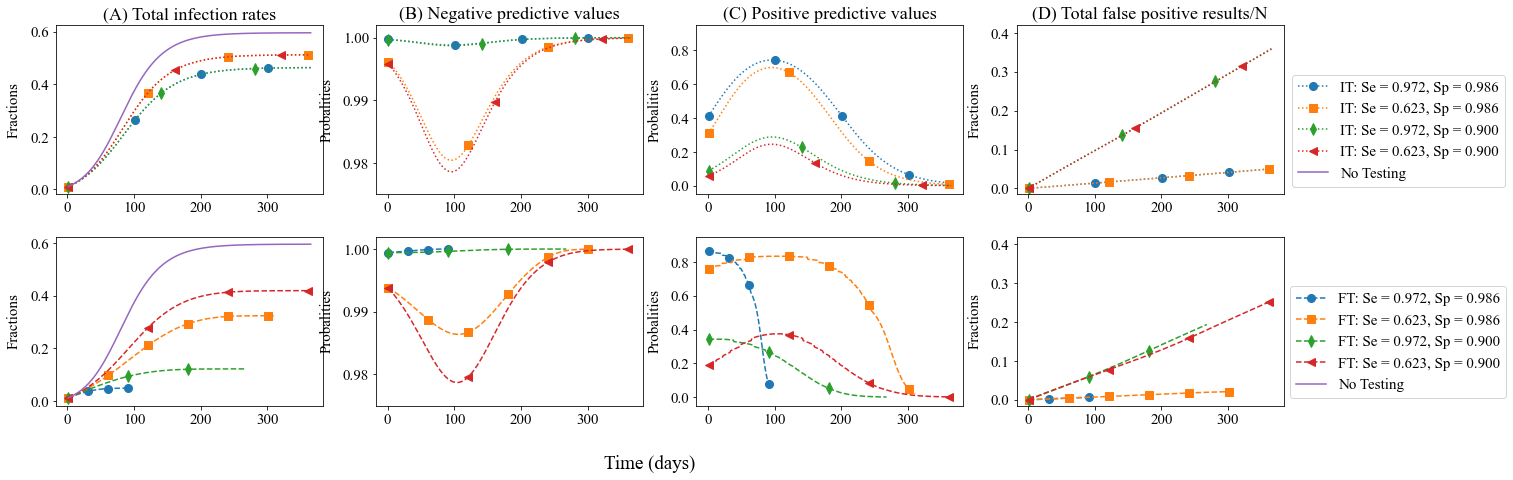

In [139]:
R_t = [1.5]
sp = [0.986, 0.9]
se = [0.972,0.623]

mk = ['o','s','d','<',]

for ri in range(len(R_t)):
    for pi in range(len(p)):
        for ci in range(len(C_0)):
            count = 0
            fig = plt.figure(figsize=(22,7))

            ax_1 = fig.add_subplot(2,4,1)
            ax_2 = fig.add_subplot(2,4,2)
            ax_3 = fig.add_subplot(2,4,3)
            ax_4 = fig.add_subplot(2,4,4)
            
            ax_5 = fig.add_subplot(2,4,5)
            ax_6 = fig.add_subplot(2,4,6)
            ax_7 = fig.add_subplot(2,4,7)
            ax_8 = fig.add_subplot(2,4,8)    
            figure_count = 0
           
            for sj in range(len(sp)):
            
                SIM_result_g = []
                SIM_result_i = []
                SIM_result_0 = []                
                
                for si in range(len(se)):
                    
                    figure_count += 1

                    count += 1
                    SIM_result_g = []
                    SIM_result_i = []
                    SIM_result_0 = []


                    # Initial number of infected and recovered individuals, I0 and R0.                
                    I0, R0, TCT0, TFP0 = p[pi],0, 0, 0
                    S0 = N - I0 - R0

    # no testing
                    y_0 = S0, I0, R0, TCT0, TFP0
                    dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                    S_0, I_0, R_0, TCT_0,TFP_0 = y_0
                    test_type = 0

                    for ti in t:
                        dy_0 = deriv_testing(y_0, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp[sj])
                        dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_0)                    
                        S_0 += dSdt*dt
                        I_0 += dIdt*dt
                        R_0+= dRdt*dt
                        TCT_0+=dTCT*dt
                        TFP_0+=dTFP*dt                      
                        y_0 = S_0, I_0, R_0, TCT_0, TFP_0
                        SIM_result_0.append([ti,S_0,I_0,R_0,TCT_0,TFP_0,n,cpr,PPV,NPV])

    # Pooled testing
                    y_g = S0, I0, R0, TCT0, TFP0
                    dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                    S_g, I_g, R_g, TCT_g,TFP_g = y_g
                    test_type = 2

                    for ti in t:                   
                        dy_g = deriv_testing(y_g, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp[sj])
                        dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_g) 
                        S_g += dSdt*dt
                        I_g += dIdt*dt
                        R_g += dRdt*dt
                        TCT_g += dTCT*dt
                        TFP_g += dTFP*dt                      
                        y_g = S_g, I_g, R_g, TCT_g,TFP_g

                        SIM_result_g.append([ti,S_g,I_g,R_g,TCT_g,TFP_g,n,cpr,PPV,NPV])


    # Individual testing
                    y_i = S0, I0, R0, TCT0, TFP0
                    dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                    S_i, I_i, R_i, TCT_i,TFP_i = y_i
                    test_type = 1 

                    for ti in t:                   
                        dy_i = deriv_testing(y_i, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp[sj])
                        dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_i) 
                        S_i += dSdt*dt
                        I_i += dIdt*dt
                        R_i += dRdt*dt
                        TCT_i += dTCT*dt
                        TFP_i += dTFP*dt                      
                        y_i = S_i, I_i, R_i, TCT_i,TFP_i

                        SIM_result_i.append([ti,S_i,I_i,R_i,TCT_i,TFP_i,n,cpr,PPV,NPV])

                    SIM_0 = pd.DataFrame(data=np.array(SIM_result_0), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                    SIM_g = pd.DataFrame(data=np.array(SIM_result_g), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                    SIM_i = pd.DataFrame(data=np.array(SIM_result_i), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])  


                    SIM_g_alpha = SIM_g.loc[SIM_g.I >= alpha]
                    SIM_i_alpha = SIM_i.loc[SIM_i.I >= alpha]
                    SIM_0_alpha = SIM_0.loc[SIM_0.I >= alpha]
                    
                    
                    if (si==0) & (sj == 0):
                        ax_1.set_title('(A) Total infection rates')
                        ax_2.set_title('(B) Negative predictive values')                        
                        ax_3.set_title('(C) Positive predictive values')          
                        ax_4.set_title('(D) Total false positive results/N')          

                    
                    ax_1.plot(SIM_i_alpha.t,1-SIM_i_alpha.S,label='IT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]), linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 80+figure_count*20)                                        
                    ax_2.plot(SIM_i_alpha.t,SIM_i_alpha.NPV,label='IT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]),  linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 80+figure_count*20)
                    ax_3.plot(SIM_i_alpha.t,SIM_i_alpha.PPV,label='IT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]),  linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 80+figure_count*20)
                    ax_4.plot(SIM_i_alpha.t,SIM_i_alpha.TFP,label='IT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]), linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 80+figure_count*20)                    

                    ax_5.plot(SIM_g_alpha.t,1-SIM_g_alpha.S,label='FT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 30*figure_count)                    
                    ax_6.plot(SIM_g_alpha.t,SIM_g_alpha.NPV, label='FT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery =30* figure_count)
                    ax_7.plot(SIM_g_alpha.t,SIM_g_alpha.PPV, label='FT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 30*figure_count)
                    ax_8.plot(SIM_g_alpha.t,SIM_g_alpha.TFP,label='FT: Se = %0.3f, Sp = %0.3f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 30*figure_count)
                    
                    ax_1.set_ylabel('Fractions')
                    ax_2.set_ylabel('Probalities')                    
                    ax_3.set_ylabel('Probalities')                    
                    ax_4.set_ylabel('Fractions')
                    
                    ax_5.set_ylabel('Fractions')
                    ax_6.set_ylabel('Probalities')                    
                    ax_7.set_ylabel('Probalities')                    
                    ax_8.set_ylabel('Fractions')


                    ax_2.set_ylim(0.975,1.002)
                    ax_6.set_ylim(0.975,1.002)
                    
                    ax_4.set_ylim(-0.015,0.42)
                    ax_8.set_ylim(-0.015,0.42)

                    ax_3.set_ylim(-0.05,0.95)
                    ax_7.set_ylim(-0.05,0.95)

                    
                    
                    
            ax_1.plot(SIM_0_alpha.t,1-SIM_0_alpha.S,label='No Testing', linestyle='solid')
            ax_5.plot(SIM_0_alpha.t,1-SIM_0_alpha.S,label='No Testing', linestyle='solid')
            ax_1.legend(loc='lower center', bbox_to_anchor=(5.03, 0),ncol=1)  
            ax_5.legend(loc='lower center', bbox_to_anchor=(5.03,0),ncol=1) 
            
plt.subplots_adjust( hspace =0.25)
fig.text(0.5,0,'Time (days)', ha='center',fontsize=19 )
fig.tight_layout()
plt.savefig('Figure_5.pdf',bbox_inches = 'tight')


## Figure 6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


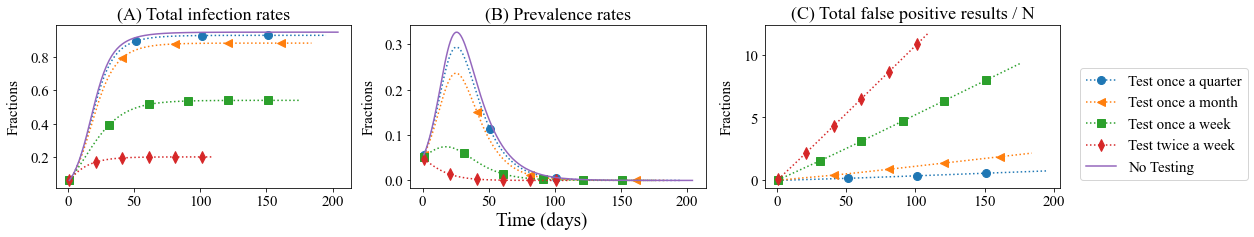

In [141]:
R_t = [3.0]
p = [0.05]
se = [0.623]
sp = [0.9]
C_0 = [0.011,0.033,0.143,0.286]

mk = ['o','<','s','d',]
lines = ['dotted',]
Figure_label =['Test once a quarter', 'Test once a month', 'Test once a week', 'Test twice a week'] 

for ri in range(len(R_t)):
    for pi in range(len(p)):
        count = 0
        fig = plt.figure(figsize=(18,3))


        for si in range(len(se)):

            SIM_result_g = []
            SIM_result_i = []
            SIM_result_0 = []                
            sp = se[si]

            count += 1
            SIM_result_g = []
            SIM_result_i = []
            SIM_result_0 = []

            ax_1 = fig.add_subplot(len(se),3,2*(count-1)+1)
            ax_2 = fig.add_subplot(len(se),3,2*(count-1)+2)
            ax_3 = fig.add_subplot(len(se),3,2*(count-1)+3)
            
            count_figure=0


            for ci in range(len(C_0)):
                count_figure += 1
                SIM_result_g = []
                SIM_result_i = []
                SIM_result_0 = []
                
                # Initial number of infected and recovered individuals, I0 and R0.                
                I0, R0, TCT0, TFP0 = p[pi],0, 0, 0
                S0 = N - I0 - R0
                
# no testing
                y_0 = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_0, I_0, R_0, TCT_0,TFP_0 = y_0
                test_type = 0

                for ti in t:
                    dy_0 = deriv_testing(y_0, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_0)                    
                    S_0 += dSdt*dt
                    I_0 += dIdt*dt
                    R_0+= dRdt*dt
                    TCT_0+=dTCT*dt
                    TFP_0+=dTFP*dt                      
                    y_0 = S_0, I_0, R_0, TCT_0, TFP_0
                    SIM_result_0.append([ti,S_0,I_0,R_0,TCT_0,TFP_0,n,cpr,PPV,NPV])
                
# Pooled testing
                y_g = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_g, I_g, R_g, TCT_g,TFP_g = y_g
                test_type = 2
                
                for ti in t:                   
                    dy_g = deriv_testing(y_g, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_g) 
                    S_g += dSdt*dt
                    I_g += dIdt*dt
                    R_g += dRdt*dt
                    TCT_g += dTCT*dt
                    TFP_g += dTFP*dt                      
                    y_g = S_g, I_g, R_g, TCT_g,TFP_g
                    
                    SIM_result_g.append([ti,S_g,I_g,R_g,TCT_g,TFP_g,n,cpr,PPV,NPV])
                    
                    
# Individual testing
                y_i = S0, I0, R0, TCT0, TFP0
                dSdt,dIdt,dRdt,dTCT,dTFP=0,0,0,0,0
                S_i, I_i, R_i, TCT_i,TFP_i = y_i
                test_type = 1 
                
                for ti in t:                   
                    dy_i = deriv_testing(y_i, test_type,R_t[ri], gamma_0, C_0[ci],se[si], sp)
                    dSdt,dIdt,dRdt,dTCT,dTFP,n,cpr,PPV,NPV = Check_null(dy_i) 
                    S_i += dSdt*dt
                    I_i += dIdt*dt
                    R_i += dRdt*dt
                    TCT_i += dTCT*dt
                    TFP_i += dTFP*dt                      
                    y_i = S_i, I_i, R_i, TCT_i,TFP_i
                    
                    SIM_result_i.append([ti,S_i,I_i,R_i,TCT_i,TFP_i,n,cpr,PPV,NPV])
                    
                SIM_0 = pd.DataFrame(data=np.array(SIM_result_0), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                SIM_g = pd.DataFrame(data=np.array(SIM_result_g), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])                                        
                SIM_i = pd.DataFrame(data=np.array(SIM_result_i), columns=['t','S','I','R','TCT','TFP','n','cpr','PPV','NPV'])  

                 
                SIM_g_alpha = SIM_g.loc[SIM_g.I >= alpha]
                SIM_i_alpha = SIM_i.loc[SIM_i.I >= alpha]
                SIM_0_alpha = SIM_0.loc[SIM_0.I >= alpha]


                ax_1.plot(SIM_i_alpha.t,1-SIM_i_alpha.S,label=Figure_label[ci], linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 60-10*count_figure)
                ax_2.plot(SIM_i_alpha.t,SIM_i_alpha.I,label=Figure_label[ci], linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 60-10*count_figure)
                ax_3.plot(SIM_i_alpha.t,SIM_i_alpha.TFP, label=r'$C_0=$%0.3f'%C_0[ci], linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 60-10*count_figure)
                
                ax_1.set_ylabel('Fractions')
                ax_2.set_ylabel('Fractions')
                ax_3.set_ylabel('Fractions')

                
                if (si==0) & (ri == 0):
                    ax_1.set_title('(A) Total infection rates')
                    ax_2.set_title('(B) Prevalence rates')
                    ax_3.set_title('(C) Total false positive results / N')  
                    
            ax_1.plot(SIM_0_alpha.t,1-SIM_0_alpha.S,label='No Testing', linestyle='solid')
            ax_2.plot(SIM_0_alpha.t,SIM_0_alpha.I,label='No Testing',linestyle='solid')

            ax_1.legend(loc='lower center', bbox_to_anchor=(3.75,0),ncol=1)  

fig.text(0.5, -0.05,'Time (days)', ha='center',fontsize=19)

plt.savefig('Figure_6.pdf',bbox_inches = 'tight')
